In [1]:
import nest
import os
import anndata
import scipy
import sklearn.metrics
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import squidpy as sq
import networkx as nx
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
import networkx as nx
import colorcet as cc

import warnings
warnings.filterwarnings("ignore")

## Computing NeST coexpression hotspots

In [2]:
dataset = "V1_Breast_Cancer_Block_A_Section_1"

neighbor_eps, min_samples, hotspot_min_size = nest.data.default_parameters(dataset)
print(neighbor_eps, min_samples, hotspot_min_size)

300 4 15


In [3]:
# Configuration for plotting and saving
dataset_dir = os.path.expanduser("~/Documents/data/")
cache_dir = os.path.expanduser(f"data/{dataset}")
image_save_dir = os.path.expanduser(f"images/{dataset}/")
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
if not os.path.exists(image_save_dir):
    os.makedirs(image_save_dir)
nest.plot.set_dataset_plot_parameters(dataset)

def save_fig(fig, name):
    fig.savefig(os.path.join(image_save_dir, name), dpi=300, bbox_inches='tight', transparent=True)

In [4]:
adata = nest.data.get_data(dataset, dataset_dir, normalize=True)

In [5]:
# Compute single-gene hotspots
num_hotspot_genes = nest.compute_gene_hotspots(adata, verbose=True,
                                               eps=neighbor_eps, min_samples=min_samples, min_size=hotspot_min_size)
print(f"{num_hotspot_genes} genes identified with hotspots.")

100%|██████████| 24923/24923 [00:32<00:00, 777.61it/s]


4247 genes identified with hotspots.


In [6]:
# Perform hotspot closure (i.e., fill in the boundaries)
nest.hotspot_closure(adata, verbose=True)

100%|██████████| 23737/23737 [01:16<00:00, 309.56it/s]


In [7]:
# Compute coexpression hotspots, shared across multiple genes
nest.coexpression_hotspots(adata, threshold=0.60, min_size=10, cutoff=0.3, min_genes=15, resolution=1.0)

In [8]:
# Identify coexpression hotspot boundaries (used in plotting)
nest.compute_multi_boundaries(adata, 10, 0.001)

## Analysis

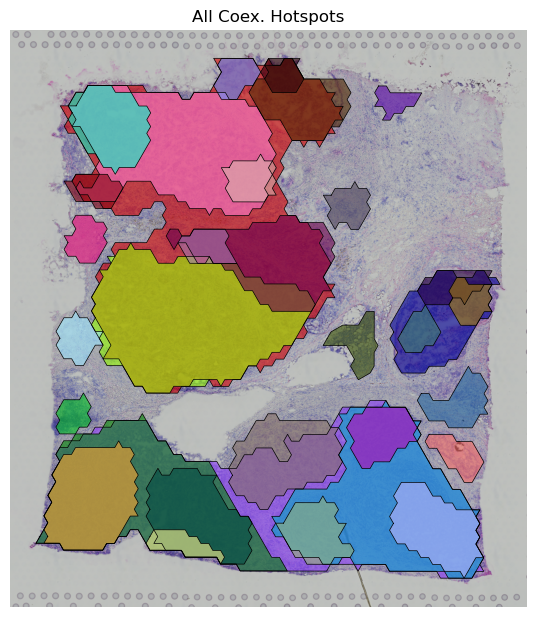

In [9]:
fig, ax = plt.subplots(1, 1, figsize=[7.5, 7.5])
nest.plot.multi_hotspots(adata, ax=ax, show=False, title="All Coex. Hotspots")
#save_fig(fig, "coex_all.png")

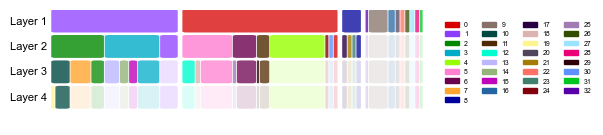

In [10]:
# Produce nested structure plot
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]
rc('font',**{'family':'serif','serif':['Arial'], 'size':5})

nest.plot.nested_structure_plot(adata, figsize=(5, 1.5), fontsize=8, legend_ncol=4, alpha_high=0.75, alpha_low=0.15,
                               legend_kwargs={'loc':"upper left", 'bbox_to_anchor':(1, 0.95)})
plt.savefig(os.path.join(image_save_dir, f'nested_structure.pdf'), dpi=300, bbox_inches='tight', transparent=True)

In [11]:
# Compute geometry scores and store in adata.obs
nest.geometry_scores(adata);

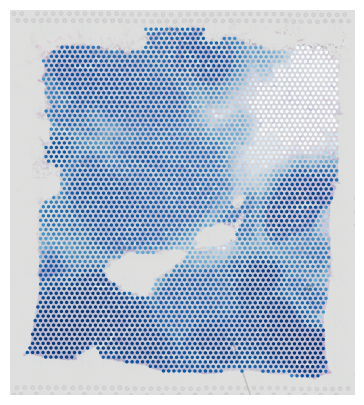

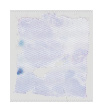

In [12]:
size = (5, 5)
fig, ax = plt.subplots(figsize=size)
nest.plot.spatial(adata, color="geometry", ax=ax, color_map="Blues", alpha_img=0.5, frameon=False, show=False,
                 title="")
ax.collections[0].colorbar.remove()
#save_fig(fig, "coherence.pdf")
size = (1.2, 1.2)
fig, ax = plt.subplots(figsize=size)
nest.plot.spatial(adata, color="geometry_unique", ax=ax, color_map="Blues", alpha_img=0.5, frameon=False, show=False,
                 title="")
ax.collections[0].colorbar.remove()
#save_fig(fig, "unique_expr.pdf")

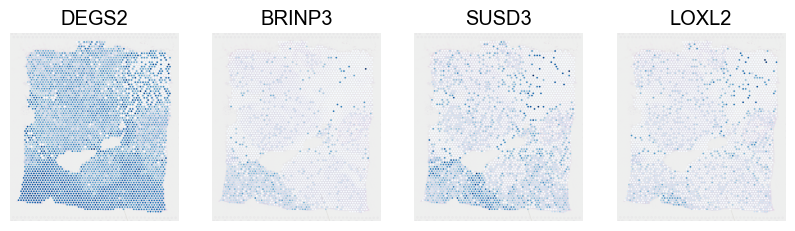

In [13]:
%matplotlib inline
rc('font',**{'family':'serif','serif':['Arial'], 'size':12})
fig, axs = plt.subplots(1, 4, figsize=[10, 5])
gene_list = ["DEGS2", "BRINP3", "SUSD3", "LOXL2"]
for idx, gene in enumerate(gene_list):
    ax=axs[idx]
    nest.plot.spatial(adata, color=gene, color_map="Blues", alpha_img=0.25, ax=ax, frameon=False, show=False)
    ax.collections[0].colorbar.remove()
    
# save_fig(fig, "top_1_markers.png")

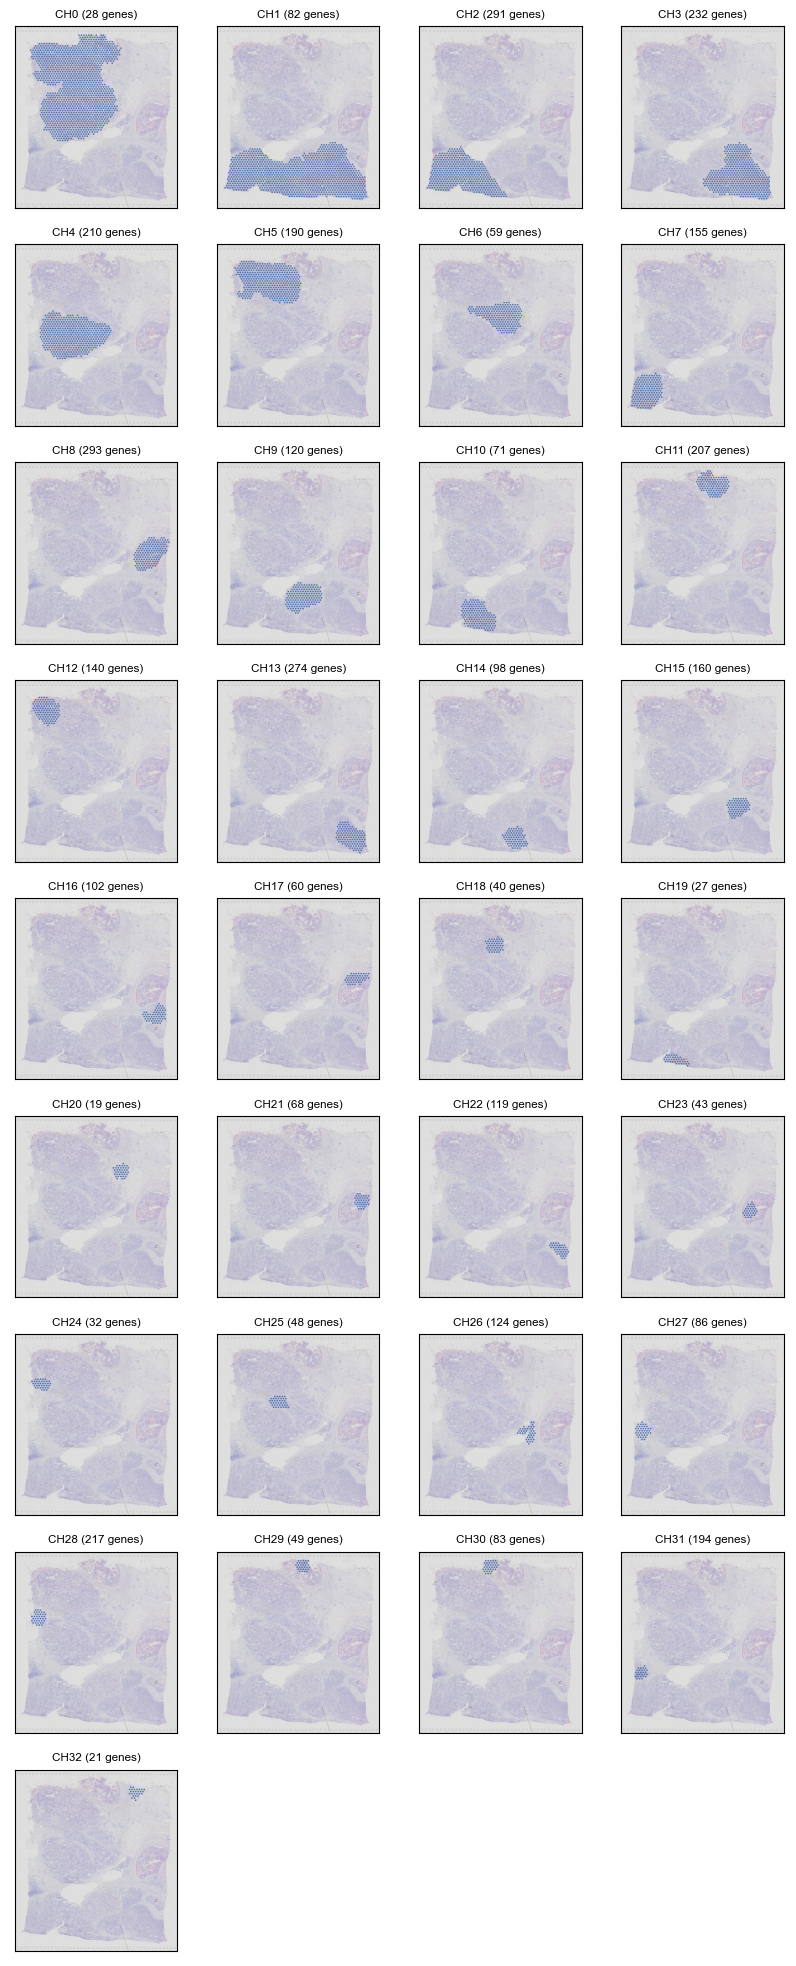

In [14]:
# Plot each coexpression hotspot individually, which makes it easier to see which coex. hotspot it is at any particular location
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]
rc('font',**{'family':'serif','serif':['Arial'], 'size':7})
sns.set_color_codes()
#keyfn = lambda x: -len(x[1])
keyfn = lambda x: int(x[0])

def plot_all_coex_hotspots(adata, ncol=4, figsize=None):
    num_coex_hotspot = len(adata.uns['multi_hotspots']) + 1
    nrow = np.ceil(num_coex_hotspot / ncol).astype(np.int_)
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    axs = axs.ravel()
    for k, multi_hotspot in sorted(adata.uns['multi_hotspots'].items(), key=keyfn):
        k = int(k)
        num_genes = len(multi_hotspot)
        nest.plot.hotspots(adata, f"multi_{k}", title=f"CH{k} ({num_genes} genes)", labels=None, palette="b", 
                         alpha_img=0.5, show=False, ax=axs[k])
    for k in range(num_coex_hotspot-1, nrow*ncol):
        axs[k].set_axis_off()


plot_all_coex_hotspots(adata, figsize=(10, 25))
#plt.savefig(os.path.expanduser(f'images/sgep_all.pdf'), dpi=300)
plt.show()

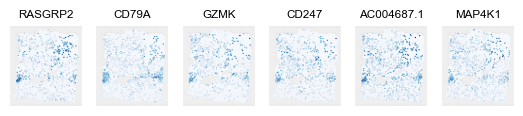

In [15]:
# Plot examples of marker genes from the TLS region identified as hotspot #30
gene_list = ["RASGRP2", "CD79A", "GZMK", "CD247", "AC004687.1", "MAP4K1"]
fig, axs = plt.subplots(1, 6, figsize=[6.5, 2])
for idx, gene in enumerate(gene_list):
    ax = axs[idx]
    nest.plot.spatial(adata, color=gene, frameon=False, ax=ax, color_map="Blues", alpha_img=0.25, show=False, spot_size=325, )
    ax.collections[0].colorbar.remove()
save_fig(fig, "tls_genes.png")

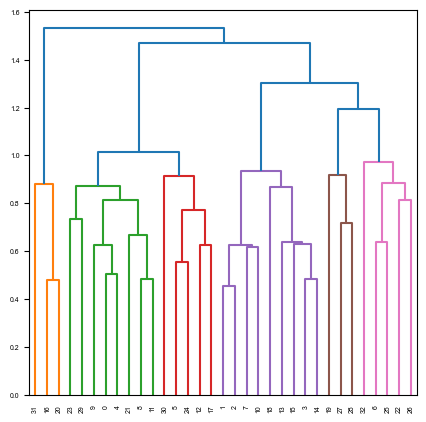

In [16]:
# Produce a dendrogram showing the similarity between coexpression hotspots
from scipy.cluster.hierarchy import dendrogram
pairwise_sim, Z = nest.sim_linkage(adata, method='ward')
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
out = dendrogram(Z, color_threshold=1.0, ax=ax, leaf_font_size=5, leaf_rotation=90)
ax.tick_params(axis='y', which='major', labelsize=5)
fig.savefig(f"images/{dataset}/dendrogram.png", dpi=300, transparent=True, bbox_inches="tight", )

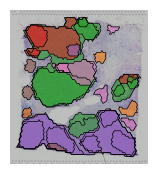

In [17]:
# Plot the coexpression hotspots, colored by the group they belong to in the dendrogram
fig, ax = plt.subplots(1, 1, figsize=[2, 2])
colors = dict(zip(out['leaves'], out['leaves_color_list']))
colors = {k: v if v is not 'C0' else (1, 1, 1, 1) for k, v in colors.items()}
nest.plot.multi_hotspots(adata, ax=ax, show=False, color_type=colors, title="")
fig.savefig(f"images/{dataset}/coex_dendro_group.png", dpi=300, transparent=True, bbox_inches="tight")

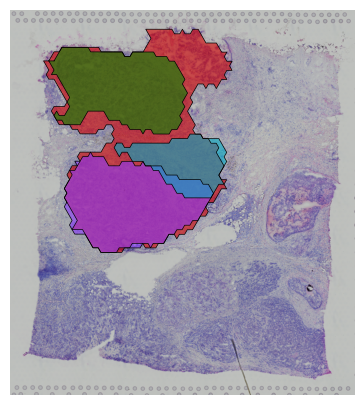

In [18]:
# Visualize the upper-left nested structure
nest.plot.multi_hotspots(adata, show=False, inds=[0, 4, 5, 6])
# Compute geometric marker genes
res = nest.geometric_markers(adata, inds=[0, 4, 5, 6], min_fc=2)

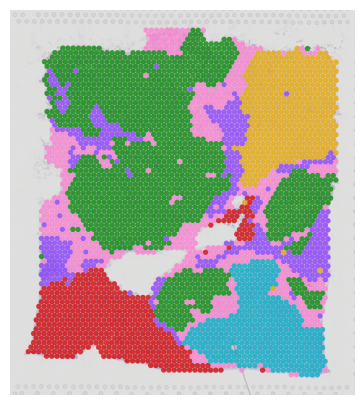

In [19]:
# NeST also contains a built-in implementation of the HMRF method
for regions in [6]:
    hmrf = nest.hmrf.HMRFSegmentationModel(adata, regions=regions, k=6, label_name=f"class_hmrf_{regions}", beta=1)
    hmrf.fit(max_iterations=200, update_labels=True, verbose=False)
    fig, ax = plt.subplots(figsize=(5, 5))
    nest.plot.spatial(adata, color=f"class_hmrf_{regions}", alpha_img=0.5, legend_loc=None, frameon=False,
                     title=f"", palette=cc.glasbey_dark, spot_size=282, alpha=0.75, ax=ax, show=False)
    #save_fig(fig, f"hmrf_segmentation_{regions}.pdf")